## Importing Relevant Libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Loading the Data

In [60]:
raw_csv_data = pd.read_csv('Index2018.csv')
raw_csv_data

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.900000,2224.95,3445.980000,18124.01
1,10/01/1994,475.270000,2225.00,3440.580000,18443.44
2,11/01/1994,474.130000,2228.10,3413.770000,18485.25
3,12/01/1994,474.170000,2182.06,3372.020000,18793.88
4,13/01/1994,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...,...
6264,23/01/2018,2839.130362,13559.60,7731.827774,24124.15
6265,24/01/2018,2837.544008,13414.74,7643.428966,23940.78
6266,25/01/2018,2839.253031,13298.36,7615.839954,23669.49
6267,26/01/2018,2872.867839,13340.17,7665.541292,23631.88


## Preprocessing the data

In [61]:
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index("date", inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

In [62]:
df_comp['market_value'] = df_comp.ftse

In [63]:
df_comp = df_comp.drop(['spx', 'dax', 'nikkei', 'ftse'], axis = 1)

In [64]:
df_comp

,market_value
date,
1994-01-07,3445.980000
1994-01-10,3440.580000
1994-01-11,3413.770000
1994-01-12,3372.020000
1994-01-13,3360.010000
...,...
2018-01-23,7731.827774
2018-01-24,7643.428966
2018-01-25,7615.839954


In [65]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## The ACF (Autocorrelation Function) 

In [66]:
import statsmodels.graphics.tsaplots as sgt

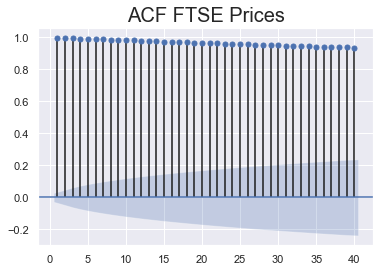

In [67]:
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title('ACF FTSE Prices', size = 20)
plt.show()

## The PACF (PArtial Autocorrelation Function)

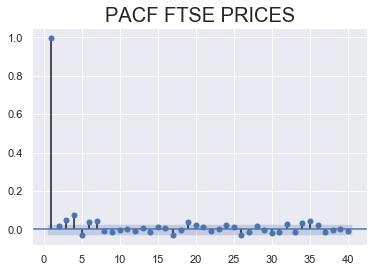

In [68]:
sgt.plot_pacf(df.market_value, lags = 40, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF FTSE PRICES", size = 20)
plt.show()

## The AR(1) Model

In [69]:
from statsmodels.tsa.arima_model import ARMA

In [70]:
model_ar = ARMA(df.market_value, order = (1,0))

In [71]:
results_ar = model_ar.fit()

In [72]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(1, 0)   Log Likelihood              -27622.601
Method:                       css-mle   S.D. of innovations             59.258
Date:                Thu, 23 Apr 2020   AIC                          55251.202
Time:                        03:25:15   BIC                          55270.766
Sample:                    01-07-1994   HQIC                         55258.058
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5080.4874    485.036     10.474      0.000    4129.834    6031.141
ar.L1.market_value     0.9985      0.001   1296.972      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
-----------------------------------------------------------------------------
"""

## Higher Lag AR Models

In [73]:
from statsmodels.tsa.arima_model import ARMA

In [74]:
model_ar_2 = ARMA(df.market_value, order = (2,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(2, 0)   Log Likelihood              -27621.866
Method:                       css-mle   S.D. of innovations             59.249
Date:                Thu, 23 Apr 2020   AIC                          55251.733
Time:                        03:25:16   BIC                          55277.818
Sample:                    01-07-1994   HQIC                         55260.873
                         - 04-05-2013                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5056.7930    494.656     10.223      0.000    4087.286    6026.300
ar.L1.market_value     0.9814      0.014     69.595      0.000       0.954       1.009
ar.L2.market_value     0.0171      0.014      1.211      0.226      -0.011       0.045
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0015           +0.0000j            1.0015            0.0000
AR.2          -58.4620           +0.0000j           58.4620            0.5000
-----------------------------------------------------------------------------
"""

## Log Likelihood Ratio(LLR) Test

In [75]:
from scipy.stats.distributions import chi2

In [76]:
def LLR_test(model_1, model_2, DF = 1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

In [77]:
LLR_test(model_ar,model_ar_2)

0.225

## Fitting AR Model with 7 Lags

In [78]:
model_ar_7 = ARMA(df.market_value, order = (7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(7, 0)   Log Likelihood              -27591.900
Method:                       css-mle   S.D. of innovations             58.896
Date:                Thu, 23 Apr 2020   AIC                          55201.799
Time:                        03:25:18   BIC                          55260.492
Sample:                    01-07-1994   HQIC                         55222.366
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6412    589.586      8.633      0.000    3934.075    6245.208
ar.L1.market_value     0.9786      0.014     69.518      0.000       0.951       1.006
ar.L2.market_value  

## Fitting AR Model with 8 Lags and Comparing using the LLR Test

In [79]:
model_ar_8 = ARMA(df.market_value, order = (8,0))
results_ar_8 = model_ar_8.fit()
print(results_ar_8.summary())
print("LLR Test p-value : " + str(LLR_test(model_ar_7, model_ar_8)))

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5021
Model:                     ARMA(8, 0)   Log Likelihood              -27591.739
Method:                       css-mle   S.D. of innovations             58.894
Date:                Thu, 23 Apr 2020   AIC                          55203.478
Time:                        03:25:21   BIC                          55268.692
Sample:                    01-07-1994   HQIC                         55226.329
                         - 04-05-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5089.6411    585.007      8.700      0.000    3943.048    6236.234
ar.L1.market_value     0.9790      0.014     69.477      0.000       0.951       1.007
ar.L2.market_value  

## Using Returns Instead of Prices

 ## The DF- Test

In [80]:
import statsmodels.tsa.stattools as sts

In [81]:
sts.adfuller(df.market_value)

(-1.9041551418836873,
 0.330108932770283,
 6,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54854.15304507557)

### Since the p-value is 0.33 we assume that the data comes from a NON-STATIONARY process

## Computing and Storing the Returns

In [82]:
df['returns']  = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## DF Test to check for stationarity

In [83]:
sts.adfuller(df.returns)

(-12.770265719497202,
 7.798058336039616e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15696.7672456975)

## Plotting the Returns ACF

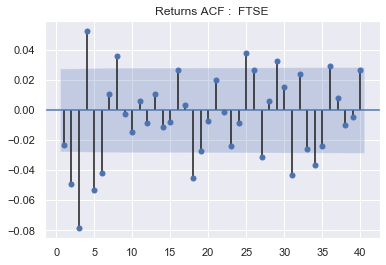

In [84]:
sgt.plot_acf(df.returns, lags = 40, zero = False)
plt.title("Returns ACF :  FTSE")
plt.show()

## Plotting the Returns PACF

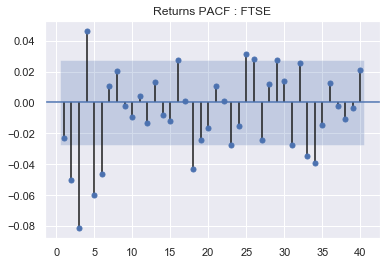

In [85]:
sgt.plot_pacf(df.returns, lags = 40, zero = False, method = ('ols'))
plt.title("Returns PACF : FTSE")
plt.show()

## AR(1) model for Returns

In [86]:
from statsmodels.tsa.arima_model import ARMA

In [87]:
model_ar_1  = ARMA(df.returns, order = (1,0))
results_ar_1 = model_ar_1.fit()
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(1, 0)   Log Likelihood               -7929.749
Method:                       css-mle   S.D. of innovations              1.174
Date:                Thu, 23 Apr 2020   AIC                          15865.497
Time:                        03:25:27   BIC                          15885.061
Sample:                    01-10-1994   HQIC                         15872.353
                         - 04-05-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0188      0.016      1.159      0.247      -0.013       0.051
ar.L1.returns    -0.0230      0.014     -1.631      0.103      -0.051       0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.4386           +0.0000j           43.4386            0.5000
-----------------------------------------------------------------------------
"""

## Higher Lag AR Models for Index Returns

In [88]:
model_ar_6 = ARMA(df.returns, order = (6,0))
results_ar_6 = model_ar_6.fit()
print(results_ar_6.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(6, 0)   Log Likelihood               -7886.945
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 23 Apr 2020   AIC                          15789.890
Time:                        03:25:28   BIC                          15842.059
Sample:                    01-10-1994   HQIC                         15808.170
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.013      1.414      0.157      -0.007       0.045
ar.L1.returns    -0.0245      0.014     -1.740      0.082      -0.052       0.003
ar.L2.returns    -0.0523      0.014     

In [89]:
model_ar_7 = ARMA(df.returns, order = (7,0))
results_ar_7 = model_ar_7.fit()
print(results_ar_7.summary())
print("LLR Test p-value: " + str(LLR_test(model_ar_6, model_ar_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood               -7886.647
Method:                       css-mle   S.D. of innovations              1.164
Date:                Thu, 23 Apr 2020   AIC                          15791.294
Time:                        03:25:28   BIC                          15849.985
Sample:                    01-10-1994   HQIC                         15811.860
                         - 04-05-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0189      0.014      1.399      0.162      -0.008       0.045
ar.L1.returns    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.returns    -0.0517      0.014     

### Since, the AR(7) model fails at all aspects and  all conditions are satisfied by  the AR(6) model, we opt for the AR(6) model

## Normailizing Values

In [90]:
benchmark = df.market_value.iloc[0]
df['norm'] = df.market_value.div(benchmark).mul(100)
sts.adfuller(df.norm)

(-1.8928710132672344,
 0.33542220743300755,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 19553.90073102193)

### Since market Prices values are not Statioinary we cannot use the Autoregression Model

### Normalizing the Returns

In [91]:
bench_ret = df.returns.iloc[0]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)
sts.adfuller(df.norm_ret)

(-12.770265719497225,
 7.798058336038833e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 80114.49116124898)

### Here, we can see that the test statistic is significant and hence the data is stationary. Therefore, this data can be used for an Autoregression Model

In [92]:
model_ar_norm_7 = ARMA(df.norm_ret, order= (7,0))
results_ar_norm_7 = model_ar_norm_7.fit()
results_ar_norm_7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               norm_ret   No. Observations:                 5020
Model:                     ARMA(7, 0)   Log Likelihood              -40308.642
Method:                       css-mle   S.D. of innovations            742.977
Date:                Thu, 23 Apr 2020   AIC                          80635.283
Time:                        03:25:31   BIC                          80693.974
Sample:                    01-10-1994   HQIC                         80655.849
                         - 04-05-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -11.9731      8.630     -1.387      0.165     -28.887       4.941
ar.L1.norm_ret    -0.0240      0.014     -1.702      0.089      -0.052       0.004
ar.L2.norm_ret    -0.0517      0.014     -3.663      0.000      -0.079      -0.024
ar.L3.norm_ret    -0.0874      0.014     -6.202      0.000      -0.115      -0.060
ar.L4.norm_ret     0.0433      0.014      3.064      0.002       0.016       0.071
ar.L5.norm_ret    -0.0601      0.014     -4.263      0.000      -0.088      -0.032
ar.L6.norm_ret    -0.0463      0.014     -3.282      0.001      -0.074      -0.019
ar.L7.norm_ret     0.0109      0.014      0.772      0.440      -0.017       0.039
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6490           -0.5384j            1.7347           -0.4498
AR.2           -1.6490           +0.5384j            1.7347            0.4498
AR.3           -0.1189           -1.4954j            1.5001           -0.2626
AR.4           -0.1189           +1.4954j            1.5001            0.2626
AR.5            1.2790           -0.9786j            1.6105           -0.1039
AR.6            1.2790           +0.9786j            1.6105            0.1039
AR.7            5.2270           -0.0000j            5.2270           -0.0000
-----------------------------------------------------------------------------
"""

### Since, the summary tables for the non-normalized returns and normalized returns contain similar values with respect to the coefficients(ø) we can conclude that normalization of data has no effect on the Autoregression

## Analyzing the Residuals

In [93]:
df['market_value_res'] = results_ar_7.resid

In [94]:
df.market_value_res.mean()

-5.2839071014950946e-05

In [95]:
df.market_value_res.var()

1.355819241347633

In [96]:
sts.adfuller(df.market_value_res)

(-70.8354903228716,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15691.957447367533)

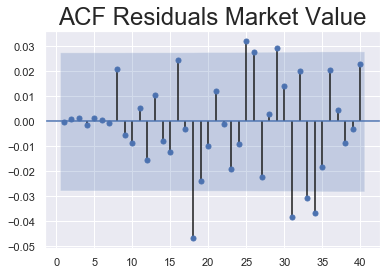

In [97]:
sgt.plot_acf(df.market_value_res, lags = 40, zero = False)
plt.title("ACF Residuals Market Value", size = 24)
plt.show()

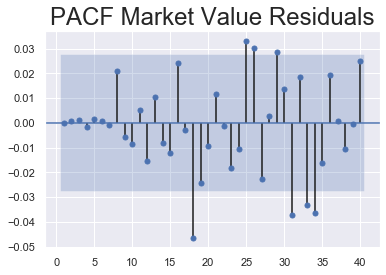

In [98]:
sgt.plot_pacf(df.market_value_res, lags = 40, zero = False, method=('ols'))
plt.title("PACF Market Value Residuals", size = 24)
plt.show()

### Both the ACF and PACF graphs show that although all the lags are not significant, there might be some good predictors

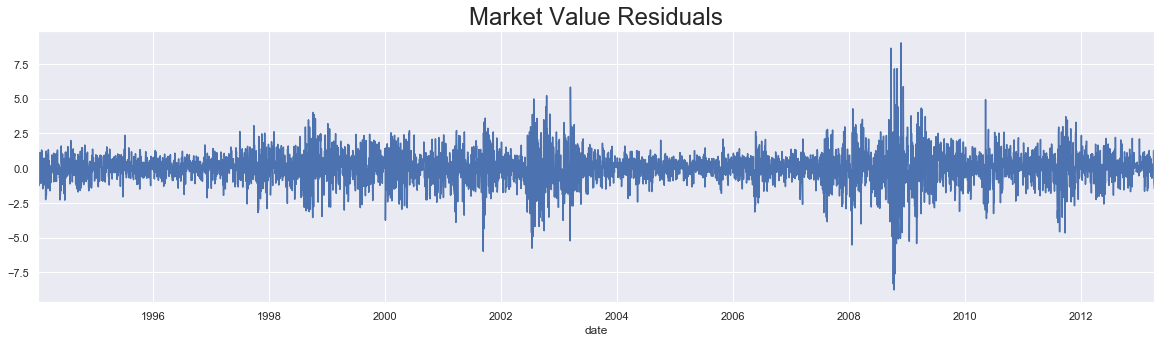

In [99]:
df.market_value_res.plot(figsize = (20,5))
plt.title("Market Value Residuals", size = 24)
plt.show()

In [102]:
df['ret_res'] = results_ar_norm_7.resid

In [103]:
df.ret_res.mean()

-0.08370792681844177

In [104]:
df.ret_res.var()

552128.0152160047

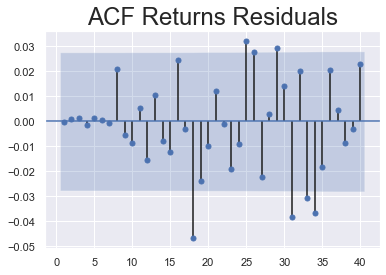

In [105]:
sgt.plot_acf(df.ret_res, lags = 40, zero = False)
plt.title("ACF Returns Residuals", size = 24)
plt.show()

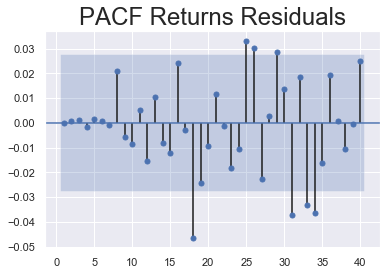

In [106]:
sgt.plot_pacf(df.ret_res, lags = 40, zero = False,  method = ('ols'))
plt.title("PACF Returns Residuals", size = 24)
plt.show()

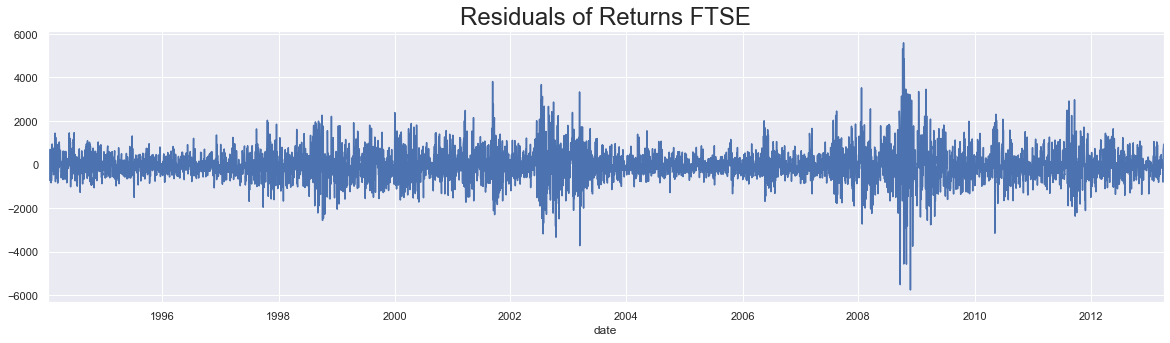

In [107]:
df.ret_res.plot(figsize = (20,5))
plt.title("Residuals of Returns FTSE", size = 24)
plt.show()